In [14]:
#all required imports
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit
import warnings
warnings.filterwarnings("ignore")
from qutip import *
from qutip.control import *
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [17]:
#creating time steps for GRAPE

T = 1
times = np.linspace(0, T, 100)

In [18]:
#writing out starting state for single qubit, we chose the fock state

psi0 = basis(2, 0)
print (psi0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]


In [4]:
#creating transform matrix RY rotation by pi, ry is a pre written QuTIP function

phi=(np.pi)
U = ry(phi)
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]

In [5]:
#Define itterations and GRAPE and Hamiltonian Terms Grape can manipluate, in real life these are your control fields 

#itterations
R = 150

#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops
H_ops = [sigmax(), sigmay(), sigmaz()]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

#writing the qubit drift hamiltonian
H0 = 0.5 * pi * sigmaz() 

print (H0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.57079633  0.        ]
 [ 0.         -1.57079633]]


In [19]:
#creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]


In [7]:
#doing GRAPE using the cy_grape_unitary function built into qutip more info about it here:https://qutip.org/docs/3.1.0/modules/qutip/control/grape.html
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   5.29s. Est. time left: 00:00:00:47
20.0%. Run time:  10.60s. Est. time left: 00:00:00:42
30.0%. Run time:  17.26s. Est. time left: 00:00:00:40
40.0%. Run time:  22.81s. Est. time left: 00:00:00:34
50.0%. Run time:  28.98s. Est. time left: 00:00:00:28
60.0%. Run time:  34.34s. Est. time left: 00:00:00:22
70.0%. Run time:  39.99s. Est. time left: 00:00:00:17
80.0%. Run time:  45.36s. Est. time left: 00:00:00:11
90.0%. Run time:  50.85s. Est. time left: 00:00:00:05
Total run time:  56.04s


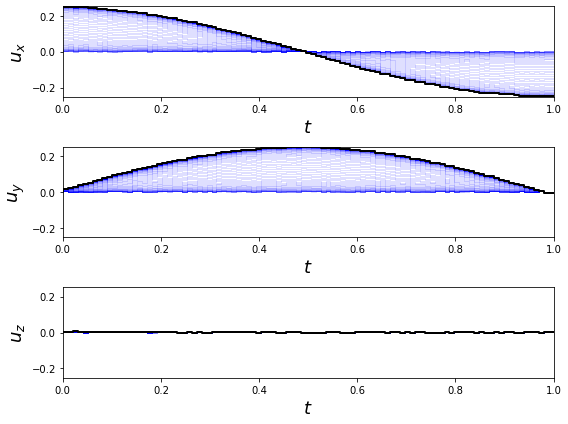

In [8]:
#Plotting pulse sqeuences from GRAPE

plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);
plt.savefig("1qubitpluse.png")


In [9]:
#Printing result U, called U_GRAPE in our report
result.U_f.tidyup(1e-6)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0. -1.]
 [ 1.  0.]]

In [10]:
#Printing the final GRAPE state to compare
finalstate=result.U_f*psi0
finalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [11]:
#printing ideal final state to compare
idealfinalstate=U*psi0
idealfinalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

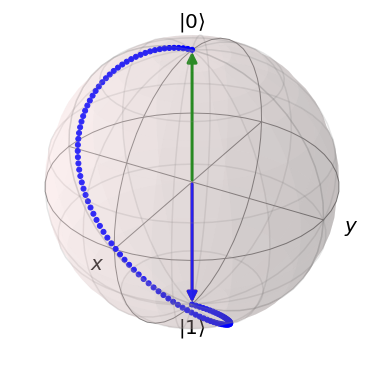

In [12]:
#plotting bloch sphere
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
U_f_numerical = propagator(result.H_t, times, c_ops, args={})
#print (U_f_numerical)
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops) # this plots all the points at during the evolution of the vector
b = Bloch()
b.add_points(me_result.expect)
b.add_states(psi0) #starting state
b.add_states(idealfinalstate) #ideal final state
b.add_states(finalstate) #final state from GRAPE
b.show()

In [20]:
#finding Fidelity

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(finalstate * finalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


0.9999999999999468